## Import Dependencies And Define Paths

In [14]:
import numpy as np 
import pandas as pd 
import os # Path joiner 
from glob import glob # Finds paths specified
# %matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.metrics import roc_curve, auc


In [15]:
# Import the data files 

rtrain =pd.read_csv( os.path.join("train_set.csv"))
rtest = pd.read_csv(os.path.join("test_set.csv"))
rval = pd.read_csv(os.path.join("val_set.csv"))

In [16]:
# Function to clean the sets and extract the labels. 

def label_cleaner(raw_df):
    # Copy the Df into two separate dataframes, one for saving as csv and one for output
    copy_df = raw_df.copy()

    # Create a column for categorical labels list in case of use
    copy_df["Labels"] = copy_df["Finding Labels"].replace("No Finding", "").str.split("|", expand = False)
    # Get a list of all diseases 
    di = list(chain(*copy_df["Finding Labels"].replace("No Finding", "").str.split("|", expand = False).tolist()))
    # Drop unnecessary columns from df 
    copy_df.drop(columns = ['Unnamed: 0', 'og_idx'], axis= 1, inplace= True )

    #Extract the list of diseases as a regualr list and as an numpy array because the model likes arrays    
    ls = np.unique(di).tolist()
    ls.remove('')
    np_ls = np.array(ls)

    return copy_df, ls, np_ls


In [17]:
train_set, labels, np_labels = label_cleaner(rtrain)
test_set, _, _ = label_cleaner(rtest)
val_set, _, _ = label_cleaner(rval)

print(f"Train Set Shape: {train_set.shape},\nTest Set Shape: {test_set.shape},\nVal Set Shape: {val_set.shape}")

Train Set Shape: (30000, 17),
Test Set Shape: (10000, 17),
Val Set Shape: (10000, 17)


In [18]:
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [19]:
np_labels

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Infiltration', 'Mass',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='<U18')

### Preprocess Image Data Using Image DataGenerators 

- Image data is preprocessed and fed into the model in batches by iterating through the directories where the images are located. 

- Ideally The images should be sorted into spearate folders but due to the high volume of images to sort, we can use the flow_from_dataframe() function instead and used the defined paths in our df.

- Images are randomly modified by flipping horizontally, rotating, slanting, shifiting etc to ensure randomization to prevent model from focusing on the wrong features during convolutions. 

- Images are 1024 x 1024; they are resized to 224 x 224 this is the standard size for the google image classifier MobileNetV2. 

- There are 3 generators. One for training data that will shuffle the imges, the testing and the validation datas images will not be shuffled. the testing data do not have labels since they will be predicted by the model. 

In [20]:
# Define image size and instantiate an Image Data Generator and define its parameters
# The parameters focus on random modifications to the images to ensure the model doesn't focus on the wrong features
# Since the image is in greyscale we don't have to worry about messing with the parameters that deal with color/ brightness
# Just the physical modifications of the images themselves. 
# We have a lot of leeway with the images since the features should be localized towards the middle most of the time.
# Don't go too wild with the modifications and shift out of range/ focus of the features.

# Image size is based on the input shape for 
image_size = (224, 224)

imdg = ImageDataGenerator(
    rescale = 1/255,
    samplewise_center = True, # Set each sample mean to 0.  
    samplewise_std_normalization = True, # Divide each input by its std. 
    horizontal_flip = True, # Flips samples horizontally randomly to prevent over fitting over wrong features
    vertical_flip = False, 
    width_shift_range=0.1, # Define how the images should be randomly shifted when fed, 10% of image 
    height_shift_range= 0.05, # Define how the images should be  randomly shifted when fed, 5% of image
    shear_range = 0.05, # slants the images in a certain degree based on the value.
    zoom_range=0.05, # magnify the images randomly by 5% 
    rotation_range= 2, # rotate the images by 2 
    fill_mode = 'reflect' # if images have empty values due to modifications, reflect the image. 
)

In [21]:
# Define the generators for each of the dataframes
train_generator = imdg.flow_from_dataframe(
    dataframe=train_set,
    x_col="path",
    y_col= np_labels,
    target_size=image_size,
    batch_size=32,
    class_mode='raw',
    shuffle=True,
    seed=10,
)
val_generator = imdg.flow_from_dataframe(
    dataframe=val_set,
    x_col="path",
    y_col= np_labels,
    target_size=image_size,
    batch_size= 256,
    class_mode='raw', 
    shuffle=False,
    seed=10,
)

test_generator = imdg.flow_from_dataframe(
    dataframe=test_set,
    x_col="path",
    target_size=image_size,
    batch_size= 10000,
    class_mode= None,
    shuffle=False,
    seed=10,
)

Found 30000 validated image filenames.
Found 10000 validated image filenames.
Found 10000 validated image filenames.


### Train the Model

- Visualize some of the images that are being fed in batches to make adjustments if they look really wonky and disrupt sample viability. 

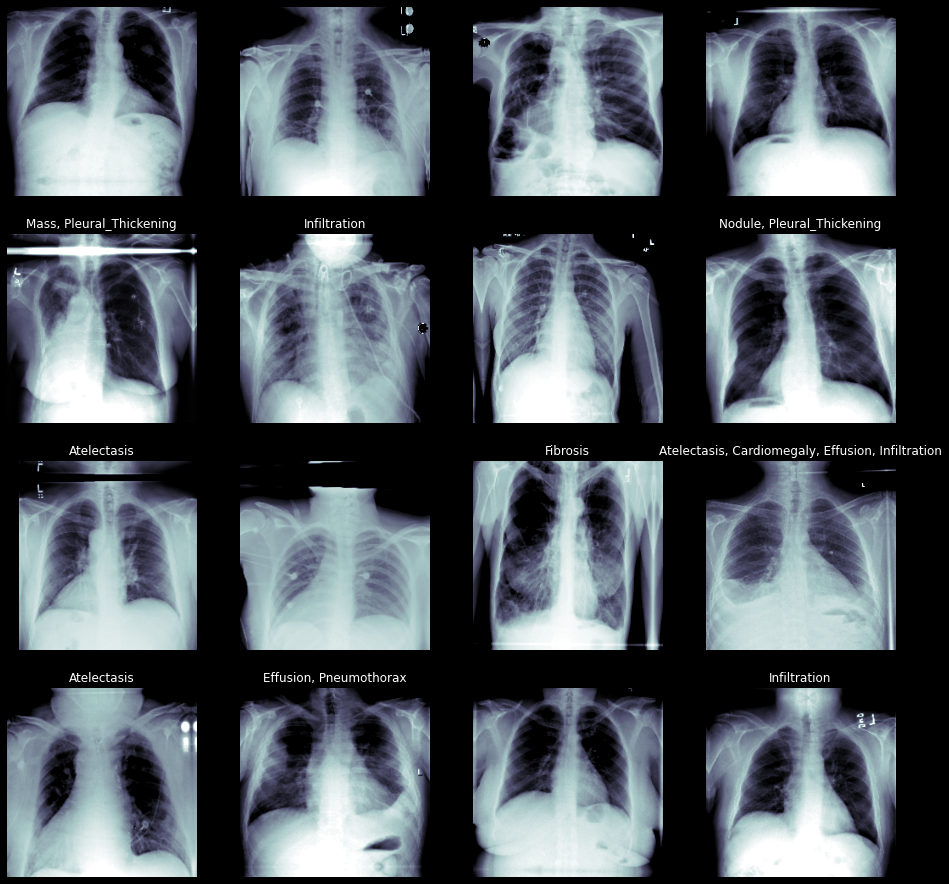

In [22]:
# Sample the images to be fed from the training set and visuzalize them
# Adjust the ImageData Generator accordingly based on output variability. 

plt.style.use('dark_background')
t_x, t_y = next(train_generator)
# instantiate a figure and axes to plug images into 
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
# Define how each of the images will be plotted each image will have its label associated so importnat to zip
# Flatten the images to reduce dimensionality
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    # Display the image using imshow along a new axies instance across all dimensions 
    # Define the color map for bones and xrays using cmap and let it cover over 150% using vmin/vmax 
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    # Loop through the labels in the target output using the labels and plot them accordingly. 
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(labels, c_y) 
                             if n_score>0.5]))
    # Turn off the axies ticks so that the images aren't cluttered. 
    c_ax.axis('off')

In [24]:
# Import Dependencies for the CNN

from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import ModelCheckpoint

In [25]:
# Differential Model Incorporating MobileNetV2

feature_extractor_layer = MobileNetV2(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)

# trainable has to be false in order to freeze the layers
feature_extractor_layer.trainable = False # 
b_model = Sequential()
b_model.add(feature_extractor_layer)
b_model.add(GlobalAveragePooling2D())
b_model.add(Dropout(0.3))
b_model.add(Flatten()) # Flatten out the tensor so that the drop out layer is not processing too much information. 
b_model.add(Dropout(0.5))
b_model.add(Dense(512, activation= 'relu', name='hidden_layer'))
b_model.add(Dropout(0.5))
b_model.add(Dense(13, activation = 'sigmoid', name='output_layer'))
b_model.compile(Adam(learning_rate=1e-5),loss="binary_crossentropy",metrics=["accuracy"])
b_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 hidden_layer (Dense)        (None, 512)               6

In [26]:
# Save checkpoints

weights = "weights/{}_weights.best/hdf5".format("modelbeta")

checkpoint = ModelCheckpoint(
    weights, monitor="val_loss", 
    verbose = 1, 
    save_best_only = True,
    mode = "min", 
    save_weights_only = True  
)


In [27]:
# Fit and train use fit_generator() to fit in the batches of images 

b_model.fit_generator(
    train_generator, 
    steps_per_epoch = train_generator.n//train_generator.batch_size, 
    validation_data = val_generator,
    validation_steps = val_generator.n//val_generator.batch_size,
    epochs = 5,
    callbacks = checkpoint 
)

c:\Users\Fabalin\Anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/5
 12/937 [..............................] - ETA: 23:22 - loss: 0.6930 - accuracy: 0.3099

KeyboardInterrupt: 

### Output Compute 

- Test data is used to make the model provide predicitions and the accuracy of the model is evaluated using the AUC/ROC curve. 

- Higher AUC, the better the model is at predicting a specific class label. The ROC Curve displays the model's classification accuracy across each label based on the true positives and false positives. Ideally, the curves for all labels should be veering towards the top left corner since we want to maximize the true positive and minimize the false positive values. 

In [ ]:
# Predict the Test Dataset 
test_generator.reset()
pred_y = b_model.predict(
    test_generator, 
    steps = test_generator.n//test_generator.batch_size,
    verbose=1)

1/1 [==============================] - 5s 5s/step


In [ ]:
# Transform the labels into a list of binaries
test_Y = test_set.apply(lambda x: [x[labels].values], axis = 1).map(lambda x: x[0])

# See the average distribution of the test set 

for c_label, s_count in zip(labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 9.33%
Cardiomegaly: 1.33%
Consolidation: 8.00%
Edema: 4.00%
Effusion: 12.00%
Emphysema: 1.33%
Fibrosis: 1.33%
Hernia: 0.00%
Infiltration: 18.67%
Mass: 4.00%
Nodule: 4.00%
Pleural_Thickening: 1.33%
Pneumonia: 1.33%
Pneumothorax: 5.33%


In [ ]:
# Transform the binarized list of labels to a numpy array or else a for loop will not be able to index well
nptest_Y = test_set[labels].to_numpy(dtype = int)
nptest_Y.shape


(75, 14)

c:\Users\Fabalin\Anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


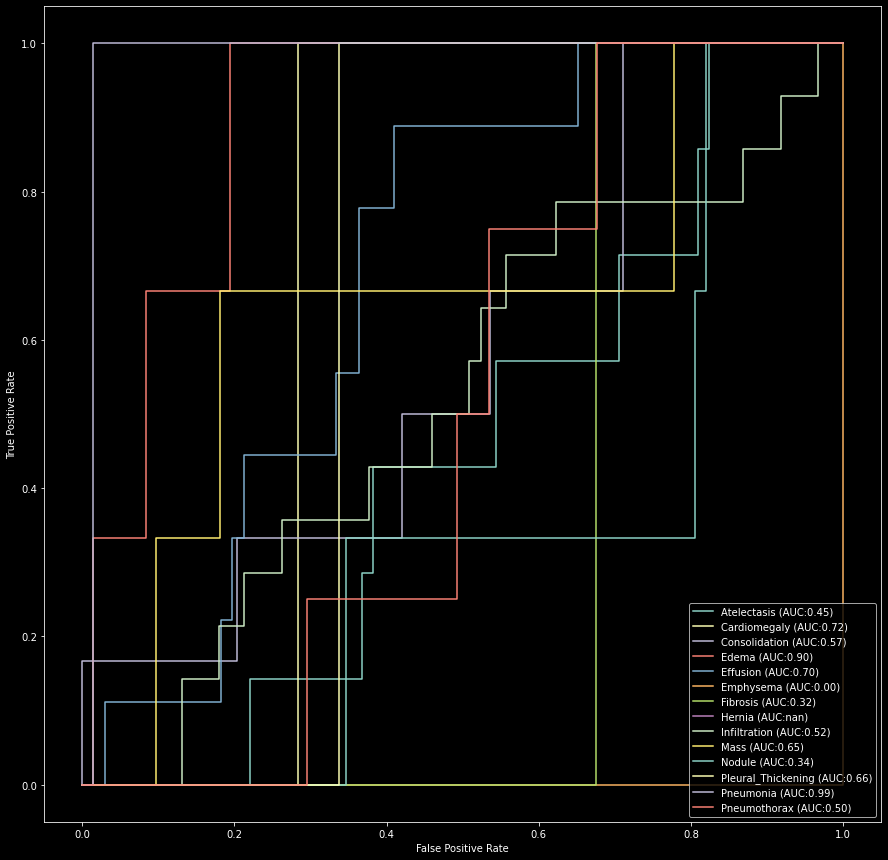

In [ ]:
# Create an AUC / ROC curve 
fig, c_ax = plt.subplots(1,1, figsize = (15, 15))

# Loop through all the labels and get the index and values. 
for (idx, c_label) in enumerate(labels):
    # create variables for the roc curve based on its output.
    #The for loop loops through all the values in the list of binarized labels based on index via column of the labels
    fpr, tpr, thresholds = roc_curve(nptest_Y[:,idx].astype(int), pred_y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('beta_5epochs.png')

In [ ]:
# See Predictions greater than 20% for the provisional model and save to csv
predictions = (pred_y > 0.2).astype(int)
columns=labels
#columns should be the same order of y_col
results=pd.DataFrame(predictions, columns=columns)
results["Filenames"]=test_set["Image Index"].tolist()
ordered_cols=["Filenames"]+columns
results=results[ordered_cols]#To get the same column order
results.to_csv('beta_net_predictions.csv')

print(results)

           Filenames  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0   00019522_009.png            1             0              0      0   
1   00025039_000.png            0             0              0      0   
2   00003906_000.png            0             0              0      0   
3   00002437_004.png            1             0              0      0   
4   00005335_001.png            1             0              0      0   
..               ...          ...           ...            ...    ...   
70  00011548_005.png            1             0              0      0   
71  00026412_011.png            1             0              0      0   
72  00005138_000.png            1             0              0      0   
73  00000324_001.png            1             0              0      0   
74  00028589_002.png            0             0              0      0   

    Effusion  Emphysema  Fibrosis  Hernia  Infiltration  Mass  Nodule  \
0          0          0         0       0         